In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode

import sys
sys.path.append('../')
from CAS import *


## ABCD-o graphs

* ground-truth saved in 'gt' vertex attribute


In [2]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/work/home/fcthebe/ABCD/ABCDGraphGenerator.jl-master/utils/'
julia = '/work/home/fcthebe/julia-1.7.2/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    g = ig.Graph.Read_Ncol(fn_net,directed=False)
    c = np.loadtxt(fn_comm,dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    g.vs['gt'] = gt
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g

In [3]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        

# Experiments

## (1) AMI vs dropped nodes, ABCD-o

* (1a) use different scores to rank the nodes (w.r.t. outlyingness), but final score w.r.t. Leiden partition
* (1b) actually use the scores for ranking AND scoring


In [4]:
## first with "mid-size" graphs
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65]
REP = 10
num_nodes = 10000
num_out = 250
delta = 10
min_comm = 50
alpha = 1


0 0.35
1 0.35
2 0.35
3 0.35
4 0.35
5 0.35
6 0.35
7 0.35
8 0.35
9 0.35
0 0.4
1 0.4
2 0.4
3 0.4
4 0.4
5 0.4
6 0.4
7 0.4
8 0.4
9 0.4
0 0.45
1 0.45
2 0.45
3 0.45
4 0.45
5 0.45
6 0.45
7 0.45
8 0.45
9 0.45
0 0.5
1 0.5
2 0.5
3 0.5
4 0.5
5 0.5
6 0.5
7 0.5
8 0.5
9 0.5
0 0.55
1 0.55
2 0.55
3 0.55
4 0.55
5 0.55
6 0.55
7 0.55
8 0.55
9 0.55
0 0.575
1 0.575
2 0.575
3 0.575
4 0.575
5 0.575
6 0.575
7 0.575
8 0.575
9 0.575
0 0.6
1 0.6
2 0.6
3 0.6
4 0.6
5 0.6
6 0.6
7 0.6
8 0.6
9 0.6
0 0.625
1 0.625
2 0.625
3 0.625
4 0.625
5 0.625
6 0.625
7 0.625
8 0.625
9 0.625
0 0.65
1 0.65
2 0.65
3 0.65
4 0.65
5 0.65
6 0.65
7 0.65
8 0.65
9 0.65


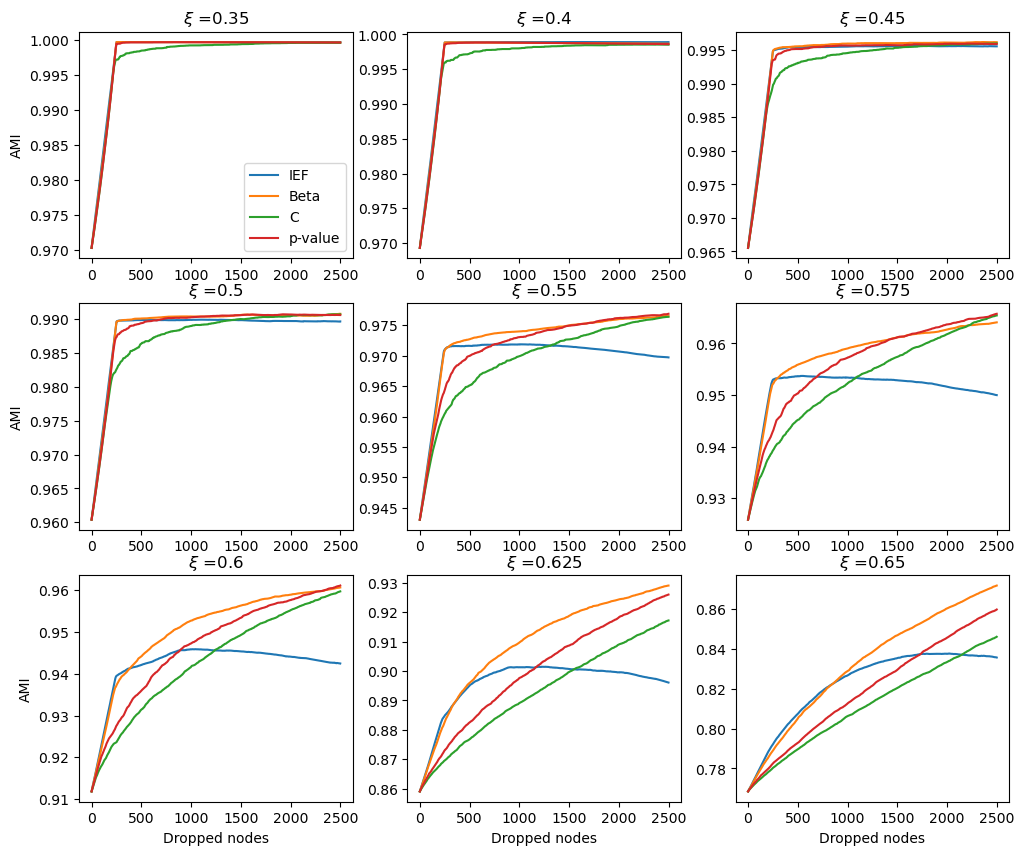

In [5]:
## Scores - only dropping 'outliers'
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    for rep in range(REP):
        print(rep, xi)
        g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, 
                            s=min_comm, tau = 0.767, nout=num_out, seed=rep)
        A = g.get_adjacency_sparse()
        ## seed for Leiden/ECG
        random.seed(rep)
        np.random.seed(rep)
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership

        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
plt.savefig('AMI_leiden.png');


0 0.35
1 0.35
2 0.35
3 0.35
4 0.35
5 0.35
6 0.35
7 0.35
8 0.35
9 0.35
0 0.4
1 0.4
2 0.4
3 0.4
4 0.4
5 0.4
6 0.4
7 0.4
8 0.4
9 0.4
0 0.45
1 0.45
2 0.45
3 0.45
4 0.45
5 0.45
6 0.45
7 0.45
8 0.45
9 0.45
0 0.5
1 0.5
2 0.5
3 0.5
4 0.5
5 0.5
6 0.5
7 0.5
8 0.5
9 0.5
0 0.55
1 0.55
2 0.55
3 0.55
4 0.55
5 0.55
6 0.55
7 0.55
8 0.55
9 0.55
0 0.575
1 0.575
2 0.575
3 0.575
4 0.575
5 0.575
6 0.575
7 0.575
8 0.575
9 0.575
0 0.6
1 0.6
2 0.6
3 0.6
4 0.6
5 0.6
6 0.6
7 0.6
8 0.6
9 0.6
0 0.625
1 0.625
2 0.625
3 0.625
4 0.625
5 0.625
6 0.625
7 0.625
8 0.625
9 0.625
0 0.65
1 0.65
2 0.65
3 0.65
4 0.65
5 0.65
6 0.65
7 0.65
8 0.65
9 0.65


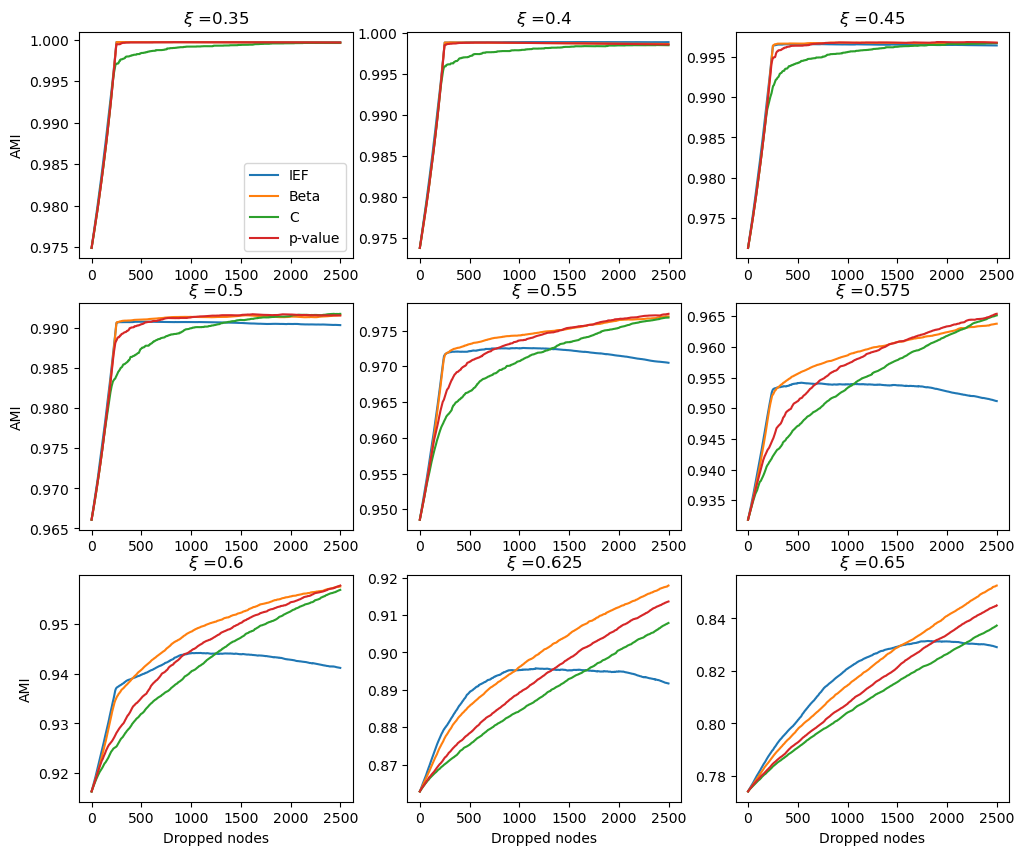

In [6]:
## Scores - using those
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    for rep in range(REP):
        print(rep, xi)
        g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, 
                            s=min_comm, tau = 0.767, nout=num_out, seed=rep)
        A = g.get_adjacency_sparse()
        ## seed for Leiden/ECG
        random.seed(rep)
        np.random.seed(rep)
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership

        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['IEF_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['beta_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['C_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()
        g.vs['P_top'] = np.array(IEF.argmax(axis=1)).flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['IEF_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['beta_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['C_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['P_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
plt.savefig('AMI_scores.png');


### (2) Classify outliers - ROC curves

0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


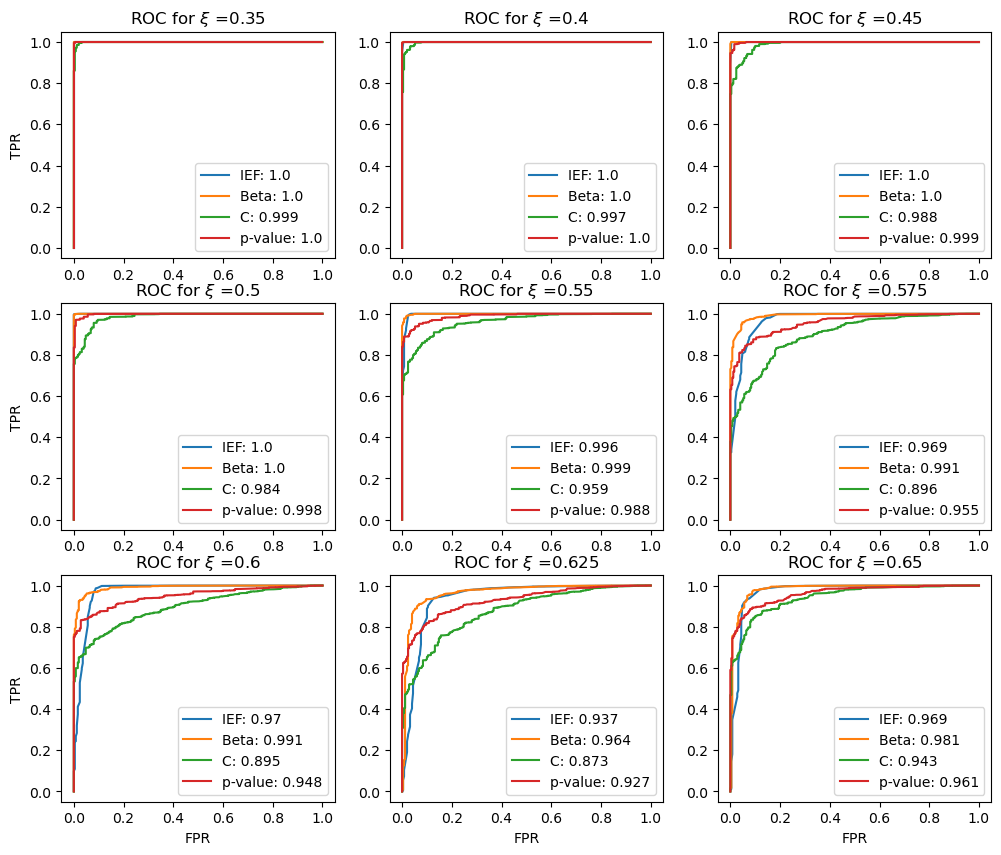

In [7]:
plt.figure(figsize=(12,10))

for i in range(len(XIs)): 
    xi = XIs[i]
    print(xi)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, 
                        tau = 0.767, nout=num_out, seed=i)
    A = g.get_adjacency_sparse()
    ## Leiden:
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    plt.subplot(3,3,i+1)

    y = [int(x>0) for x in g.vs['gt']]

    g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['IEF'], pos_label=1)
    auc = AUC(y, g.vs['IEF'])
    plt.plot(fpr, tpr, label='IEF: '+str(round(auc,3)))

    g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['beta'], pos_label=1)
    auc = AUC(y, g.vs['beta'])
    plt.plot(fpr, tpr, label='Beta: '+str(round(auc,3)))

    g.vs['C'] = C.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['C'], pos_label=1)
    auc = AUC(y, g.vs['C'])
    plt.plot(fpr, tpr, label='C: '+str(round(auc,3)))

    g.vs['P'] = P.max(axis=1).toarray().flatten()
    fpr, tpr, thresholds = roc_curve(y, g.vs['P'], pos_label=1)
    auc = AUC(y, g.vs['P'])
    plt.plot(fpr, tpr, label='p-value: '+str(round(auc,3)))

    plt.legend(title='AUC')
    if i>5:
        plt.xlabel('FPR')
    if i%3==0:
        plt.ylabel('TPR');
    plt.legend()
    plt.title(r'ROC for $\xi$ ='+str(xi))  
plt.savefig('ROC_scores.png')    


### (3) Scores, varying threshold

In [21]:
%%time

range_IEF = np.arange(.05,.501,.025)
range_beta = np.arange(.05,.501,.025)
range_C = np.arange(1,8.001,.25)
range_P = np.arange(.95,1,.0025)

L = []
for xi in XIs:
    print(xi)
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, 
                        s=min_comm, tau = 0.767, nout=num_out)
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    A = g.get_adjacency_sparse()
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
    for th in range_IEF:
        M = score_to_memberships(IEF, DegPart, th)
        L.append(['IEF', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_beta:
        M = score_to_memberships(Beta, DegPart, th)
        L.append(['Beta', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_C:
        M = score_to_memberships(C, DegPart, th)
        L.append(['C', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_P:
        M = score_to_memberships(P, DegPart, th)
        L.append(['P', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])

df = pd.DataFrame(L, columns=['score','xi','threshold','outliers','TP'])
df['FP'] = df['outliers'] - df['TP']


0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65
CPU times: user 53.9 s, sys: 64 ms, total: 54 s
Wall time: 1min 45s


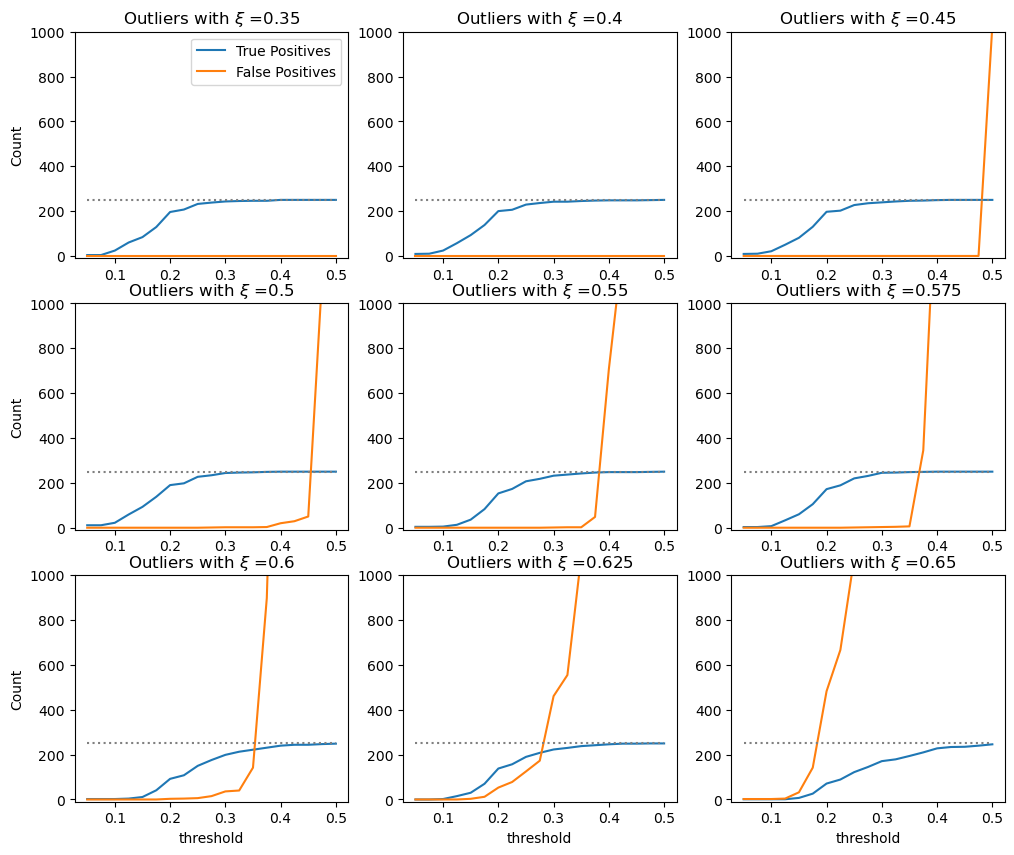

In [22]:
_df = df[df.score == 'IEF']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
plt.savefig('TP_FP_IEF.png');    


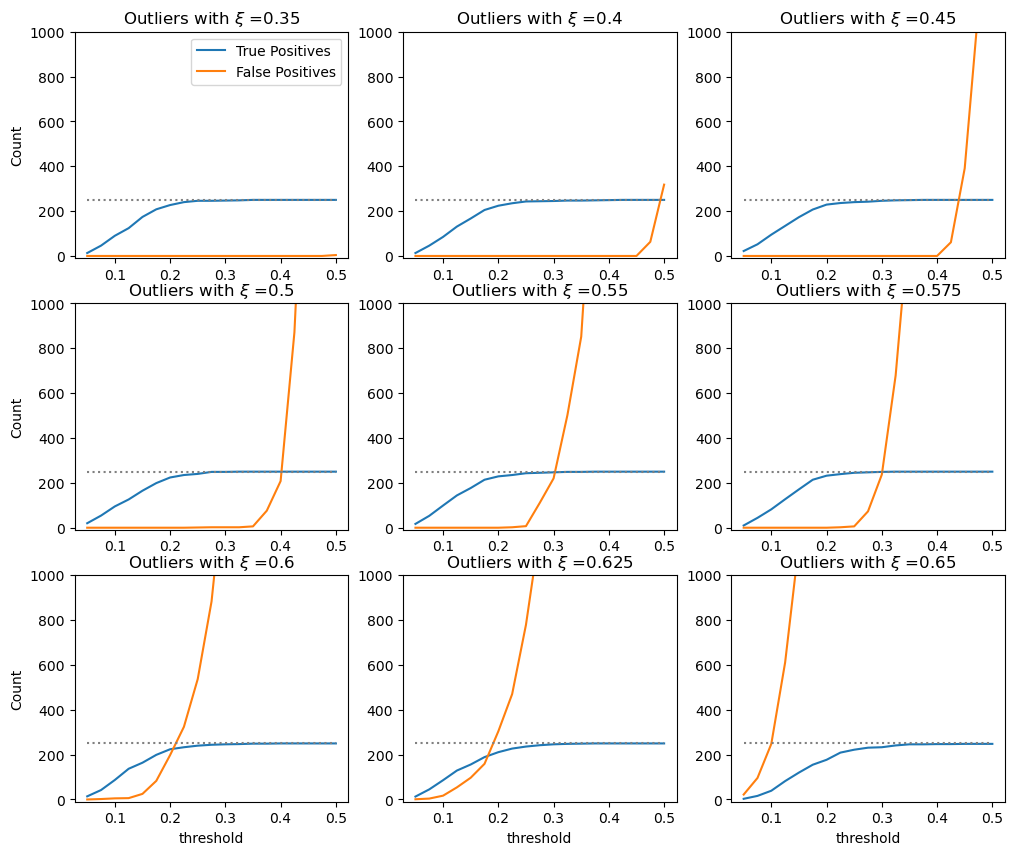

In [23]:
_df = df[df.score == 'Beta']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
plt.savefig('TP_FP_Beta.png');    


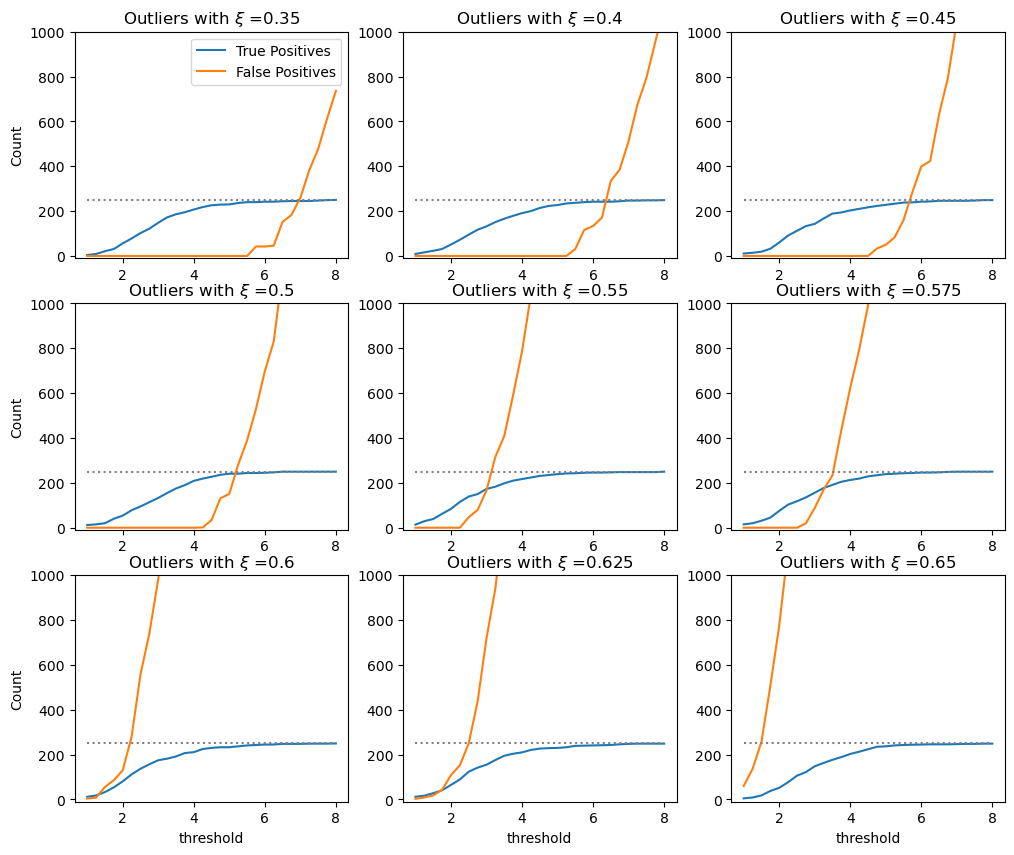

In [24]:
_df = df[df.score == 'C']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
plt.savefig('TP_FP_C.png');    


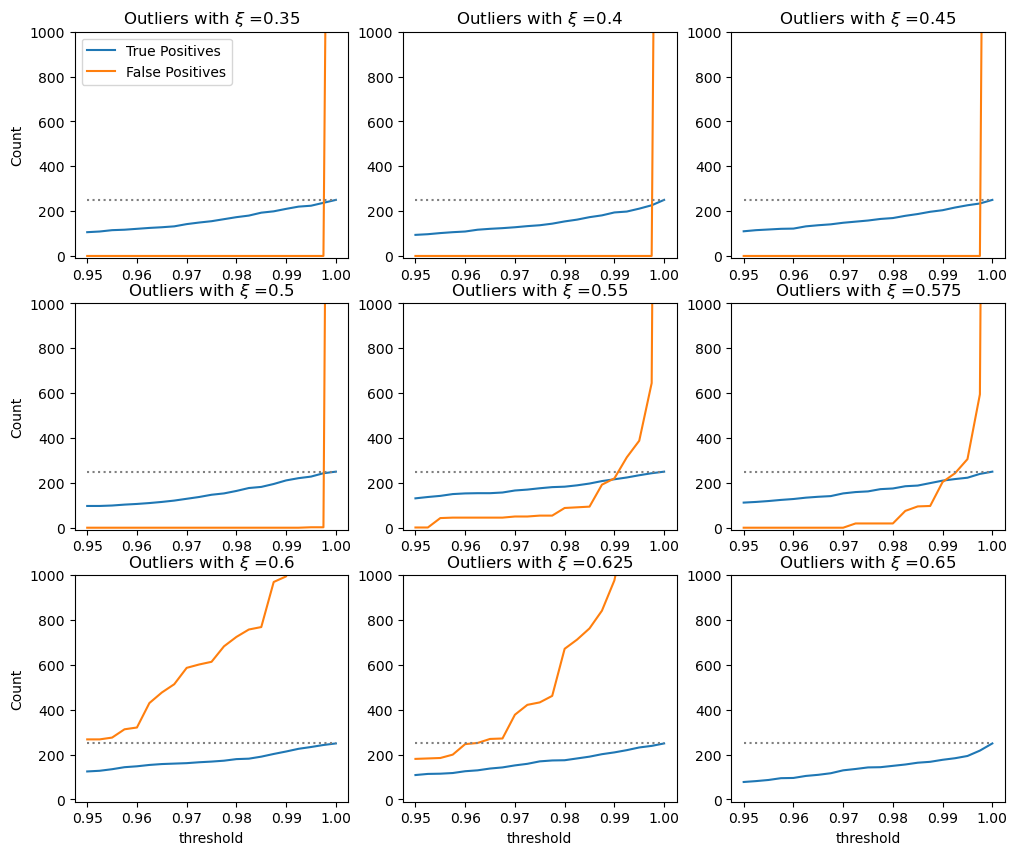

In [25]:
_df = df[df.score == 'P']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
plt.savefig('TP_FP_P.png');    
